In [284]:
import sys
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk
import re
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('words')
stopwords = stopwords.words('english')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [308]:
# Method 1: tfidf
class tfidfVec:
    
    def __init__(self, df, extrastop):
        # english word set
        self.words = set(nltk.corpus.words.words())
        self.df = df
        self.extra_stop = extrastop

    def clean(self):
        #remove non-english
        self.df['cleaned'] = self.df['Description'].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in self.words or not w.isalpha()))
        #remove stop words
        self.df['cleaned'] = self.df['cleaned'].apply(lambda x: " ".join(a for a in x.split() if a not in stop_words))
        #lemmatize
        self.df['cleaned'] = self.df['cleaned'].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))
        # remove 2 char
        self.df['cleaned'] = self.df['cleaned'].apply(lambda x:" ".join(word for word in x.split() if len(word)>2))
        # further remove meaningless words
        for s in self.extra_stop:
            self.df['cleaned'] = self.df['cleaned'].str.replace(s,"")
        #stem
    #     porter = PorterStemmer()
    #     df['cleaned'] = df['cleaned'].apply(lambda x:" ".join(porter.stem(word) for word in x.split()))
 
    def process(self, maxd, mind, ngram, maxf):
        corpus = self.df['cleaned'].tolist()
        vectorizer=TfidfVectorizer(max_df=maxd, min_df=mind, ngram_range = (1, ngram), max_features=maxf, use_idf=True)
        X = vectorizer.fit_transform(corpus)
        feature_array = vectorizer.get_feature_names_out()

        top_n = maxf
        norow = self.df.shape[0]

        return sorted(list(zip(vectorizer.get_feature_names_out(), 
                                             X.sum(0).getA1()/norow)), 
                                 key=lambda x: x[1], reverse=True)[:top_n]

In [309]:
# Method 2

# try to locate the skills block "Requirements" or "Qualifications" on the web page by searching for key words
# after finding words like "requirement", "qualification", "skill", extract 80 words or 640 char after that 
# use the extracted words to generate count vectorizor or tfidf vectorizor

In [323]:
class CustomizedSearching:
    
    def __init__(self, skillSign, df, extra_stop):
        self.skillSign = skillSign
        self.df = df
        self.extra_stop = extra_stop

    def extract(self, df_string):
        extract_words = []
        word_list = df_string.split()
        for w in word_list:
            if w in skillSign:
                i = word_list.index(w)
                extract_words += word_list[i:i+80]
        return " ".join(extract_words)

    
    def extractString(self, df_string):
        #find the string index and get 8*80 char
        extract_words = []
        extract_string = ""
        for w in skillSign:
            indexes = [m.start() for m in re.finditer(w, df_string)]
            for i in indexes:
                extract_string += " "+df_string[i:i+640]

        extracted_words = [x for x in extract_string.split() if len(x)>2]
        return " ".join(extract_words)

    
    def searchSkillBlock(self):
        #remove stop words
        self.df['extracted'] = self.df['Description'].apply(lambda x: " ".join(a for a in x.split() if a not in stop_words))
        #lemmatize
        self.df['extracted'] = self.df['extracted'].apply(lambda x:" ".join([Word(word).lemmatize() for word in x.split()]))

        # extract 80 words after each occurence of skillSign
        self.df['extracted'] = self.df['extracted'].apply(extract)

        # extract 640 char after each occurence of skillSign as a substring e.g. endskills
        for index, row in self.df.iterrows():
            if row['extracted']=='':
                row['extracted'] = extractString(row['extracted'])


        # further remove meaningless words
        for s in self.extra_stop:
            self.df['extracted'] = self.df['extracted'].str.replace(s,"")

    
    def countVec(self):
        corpus = self.df['extracted'].tolist()
        vectorizer=CountVectorizer(max_df=1.0, min_df=0.2, ngram_range = (1, 2), max_features=20)
        X = vectorizer.fit_transform(corpus)
        feature_array = vectorizer.get_feature_names_out()

        top_n = 20
        norow = self.df.shape[0]

        return sorted(list(zip(vectorizer.get_feature_names_out(), 
                                             X.sum(0).getA1()/norow)), 
                                 key=lambda x: x[1], reverse=True)[:top_n]
    
    def tfidfVec(self):
        corpus = self.df['extracted'].tolist()
        vectorizer=TfidfVectorizer(max_df=1.0, min_df=0.2, ngram_range = (1, 2), max_features=20, use_idf=True)
        X = vectorizer.fit_transform(corpus)
        feature_array = vectorizer.get_feature_names_out()

        top_n = 20
        norow = self.df.shape[0]

        return sorted(list(zip(vectorizer.get_feature_names_out(), 
                                             X.sum(0).getA1()/norow)), 
                                 key=lambda x: x[1], reverse=True)[:top_n]
        

In [326]:
class getSkills:
    def __init__(self, job_title, jobfile):
        # read from csv and do general cleaning
        self.df = pd.read_csv(jobfile)
        self.df= self.df.dropna()

        # remove everything except word characters (inclusing special char, digits and underscore)
        self.df['Description'] = self.df['Description'].str.replace(r'\W', ' ', regex=True)
        self.df['Description'] = self.df['Description'].str.replace(r'\d+', '', regex=True)
        self.df['Description'] = self.df['Description'].str.replace("_", '')
        # lowercase
        self.df['Description'] = self.df['Description'].apply(lambda x: x.lower())
        
    def getMethod1(self, extrastop):
        tfidfMethod = tfidfVec(self.df, extrastop)
        tfidfMethod.clean()
        tfidf = tfidfMethod.process(2.0, 0.5, 2, 20)
        return tfidf
    
    def getMethod2(self, extrastop):
        skillSign = ["requirement", "qualification", "skill"]
        myMethod = CustomizedSearching(skillSign, self.df, extrastop)
        myMethod.searchSkillBlock()
        c = myMethod.countVec()
        t = myMethod.tfidfVec()
        return c,t

In [347]:
skill_ds = getSkills("data scientist","data_ds.csv")
extra_stop_words = ["work","ability","skill","year","requirement", "qualification","strong", "tool", "ing", "development","product", "solution"]
t1 = skill_ds.getMethod1(extra_stop_words)
c, t2 = skill_ds.getMethod2(extra_stop_words)
df_ds = skill_ds.df
print("Final results for data scientist:")
print("\n")
print("First method tfidf top 20:")
print(t1)
print("\n")
print("Second method count top 20:")
print(c)
print("\n")
print("Second method tfidf top 20:")
print(t2)

Final results for data scientist:


First method tfidf top 20:
[('data', 0.4745309723037524), ('experience', 0.2562409372411891), ('learn', 0.21741967975425838), ('business', 0.19430043251834614), ('team', 0.18543229194463734), ('machine', 0.1529591042978648), ('machine learn', 0.14845198480721547), ('analytics', 0.13411077451607425), ('science', 0.12741647448115886), ('build', 0.11699428945000243), ('analysis', 0.1059335505237994), ('engineer', 0.09744002242886084), ('new', 0.09501028884584822), ('knowledge', 0.09391096055039992), ('data science', 0.09095950302422869), ('help', 0.08879748154398966), ('design', 0.08771769283194432), ('support', 0.08477634817727388), ('technical', 0.08282301184291198), ('understand', 0.08174505460120045)]


Second method count top 20:
[('data', 7.4185303514377), ('experience', 5.567625133120341), ('business', 2.617678381256656), ('learn', 2.5228966986155483), ('team', 2.252396166134185), ('science', 1.8519701810436635), ('machine', 1.516506922257721), (

In [348]:
skill_sd = getSkills("software developer","data_sd.csv")
extra_stop_words = ["work","working","time","ability","skill","year","requirement", "qualification","strong", "tool", "ing", "development","product", "solution","develop", "new"]
t_sd1 = skill_sd.getMethod1(extra_stop_words)
c_sd2, t_sd2 = skill_sd.getMethod2(extra_stop_words)
df_sd = skill_sd.df
print("Final results for software developer:")
print("\n")
print("First method tfidf top 20:")
print(t_sd1)
print("\n")
print("Second method count top 20:")
print(c_sd2)
print("\n")
print("Second method tfidf top 20:")
print(t_sd2)

Final results for software developer:


First method tfidf top 20:
[('experience', 0.36315990797403175), ('team', 0.2899107897934766), ('design', 0.1989588877278291), ('test', 0.16643072740503162), ('code', 0.1604026579337243), ('knowledge', 0.15305727672595665), ('build', 0.14914541087724317), ('technical', 0.13604905620153687), ('technology', 0.13468307185121287), ('environment', 0.1340344319246207), ('er', 0.13389282520859083), ('computer', 0.13382761218268285), ('company', 0.13219381676187777), ('job', 0.125825006138966), ('full', 0.12391009289097059), ('look', 0.1135175757275613)]


Second method count top 20:
[('experience', 4.693140794223827), ('software', 3.1958483754512637), ('design', 2.1796028880866425), ('team', 2.032490974729242), ('test', 1.78971119133574), ('application', 1.6525270758122743), ('knowledge', 1.48014440433213), ('technology', 1.3005415162454874), ('system', 1.2851985559566788), ('technical', 1.2382671480144405), ('code', 1.227436823104693), ('computer', 1.1

In [349]:
# tests 
def getOneUniqueString(x, df):
    return " ".join(set(df['extracted'][x].split()))
    
def getCleanedString(x,df):
    return " ".join(set(df['cleaned'][x].split()))
    
#ds data test
index = 0
print("Data Scientist checking...")
print("After cleanning using method 1:\n"+getCleanedString(index,df_ds))
print()
print("After cleanning using method 2:\n"+getOneUniqueString(index,df_ds))
print("\n\n\n")
#sd data test
print("Software Developer checking...")
print("After cleanning using method 1:\n"+getCleanedString(index,df_sd))
print()
print("After cleanning using method 2:\n"+getOneUniqueString(index,df_sd))


Data Scientist checking...
After cleanning using method 1:
challenge company organization role collaborate platform global collaborative present problem goal speed knowledge capital technology scientist help equity python computer page job support keep growth complex structured every acumen better passion think analytical make per combine degree everyone aggregate paced create raw intelligence field active analyze presentation research industry eye extract business algebra data preferred learn full team knack private engineer across information innovative rapidly revolutionize culture based compensation math aptitude predictive experience ecosystem collection tech undertake vision large discover competitive proprietary graduate type understand relevant communication innovation highly identify opportunity mind modern well day statistic access rely backed proven north efficiency machine propose ensemble earn funded neural build quantitative visualization tableau market globally excellent

In [335]:
# calculate Bhattacharyya coefficient
from dictances import bhattacharyya_coefficient

ds_dictionary = dict(t2)

sd_dictionary = dict(t_sd2)

bhattacharyya_coefficient(ds_dictionary, sd_dictionary)

0.8261202310811527

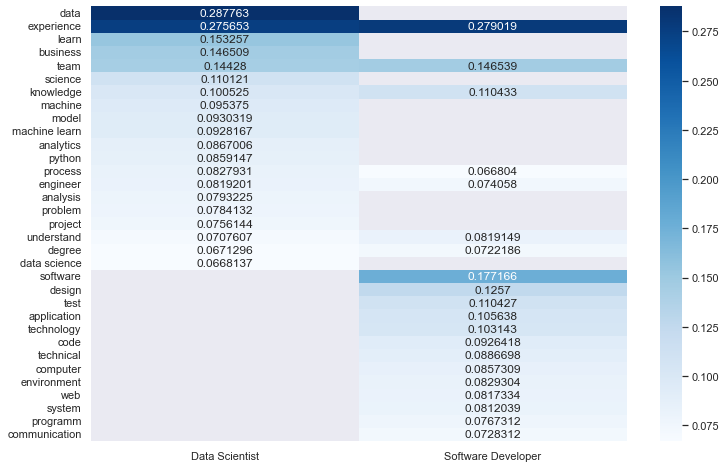

In [346]:
a={"Data Scientist":ds_dictionary, "Software Developer": sd_dictionary}
import seaborn as sns
sns.set(rc={"figure.figsize":(12,8)})

df = pd.DataFrame(a)
g = sns.heatmap(df, cmap="Blues", annot=True, fmt='g')
g.get_figure().savefig("heatmap.png")